In [41]:
%reload_ext autoreload
%autoreload 2

import projcore as pc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

In [29]:
pc.download_kaggle_datasets()
battles_df = pd.read_csv('BattlesStaging_01012021_WL_tagged.csv')
card_list_df = pd.read_csv('CardMasterListSeason18_12082020.csv')
winning_card_list_df = pd.read_csv('Wincons.csv')

File BattlesStaging_01012021_WL_tagged/BattlesStaging_01012021_WL_tagged.csv already exists, skipping download
File CardMasterListSeason18_12082020.csv already exists, skipping download
File Wincons.csv already exists, skipping download
clash-royal-data.csv already exists, skipping download


In [30]:
battles_df = pc.feature_preprocessing(battles_df, winning_card_list_df)

In [73]:
battles_df.head(100).to_csv("battles_subset.csv", index=False)


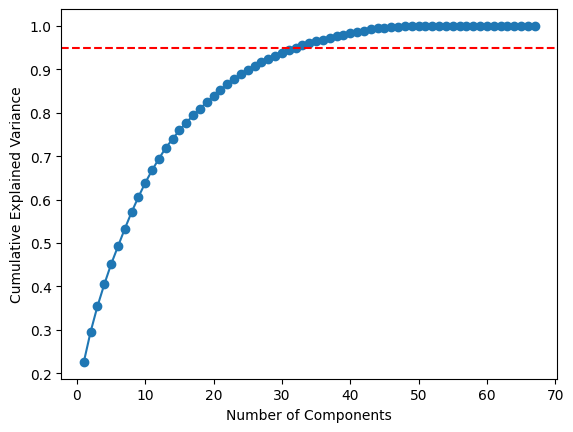

Best component: 32 with a cumulative_variance value of: 0.9502
Explained Variance Ratio: 0.9501578808180144
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.506051  1.836344 -3.321393 -2.599018  3.155205 -0.550332 -0.144690   
1  2.564232 -2.831465  2.128652  1.284613  1.119239 -1.252368 -0.378485   
2  3.528941  1.433013  1.903784  0.032887  2.663266 -1.667474 -1.898063   
3 -3.275349 -2.168384  0.207298 -0.450833  4.439630  0.946909  0.590947   
4  4.790789 -0.188127 -1.087195 -2.345725  2.869775 -3.510066  0.904039   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.615344  1.802723  0.817248  3.778600 -0.762039  0.864248  1.395408   
1 -0.327422 -0.993402 -0.759375  0.754002 -0.701091 -0.003360  1.462460   
2 -1.094621 -2.496128 -0.447494 -1.166143  1.216284 -0.987320 -0.692955   
3 -1.736385 -0.181494 -2.745223 -0.625609 -1.999091 -2.006515 -0.323957   
4 -1.672497 -3.293054  0.600646  0.241491  3.461495 -1.930646  1.3

In [57]:
filtered_df, n = pc.get_pca_optimal_components(battles_df)  
pca_n = PCA(n_components=n)
pca_for_df = pca_n.fit_transform(filtered_df)
df_pca = pd.DataFrame(pca_for_df, columns=[f"PC{i+1}" for i in range(n)])

print("Explained Variance Ratio:", pca_n.explained_variance_ratio_.sum())
print(df_pca.head())

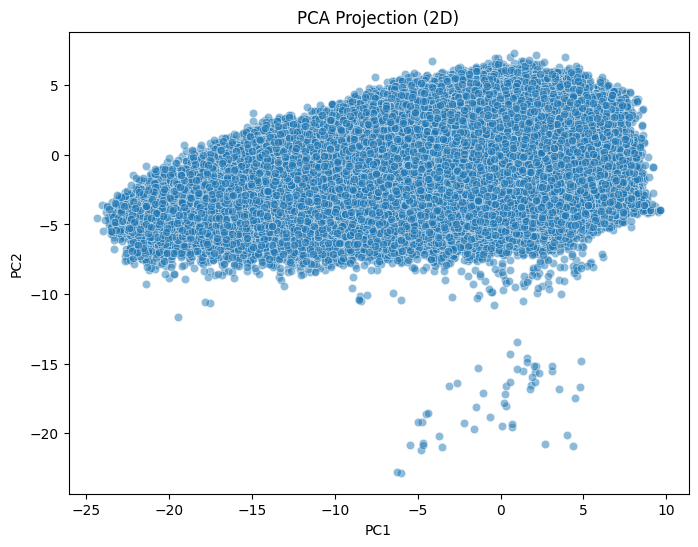

In [58]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=n)
df_pca = pca.fit_transform(filtered_df)

# Convert PCA results into DataFrame
df_pca = pd.DataFrame(df_pca, columns=[f"PC{i+1}" for i in range(n)])

# Reduce to 2D for visualization
pca_2d = PCA(n_components=2)
pca_2d_transformed = pca_2d.fit_transform(filtered_df)
df_pca_2d = pd.DataFrame(pca_2d_transformed, columns=["PC1", "PC2"])

plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", data=df_pca_2d, alpha=0.5)
plt.title("PCA Projection (2D)")
plt.show()

/Users/roni/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


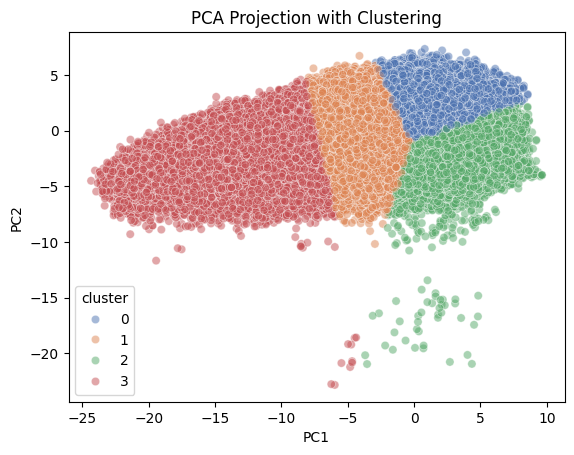

In [59]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
df_pca_2d["cluster"] = kmeans.fit_predict(df_pca_2d[["PC1", "PC2"]])

sns.scatterplot(x="PC1", y="PC2", hue=df_pca_2d["cluster"], palette="deep", data=df_pca_2d, alpha=0.5)
plt.title("PCA Projection with Clustering")
plt.show()

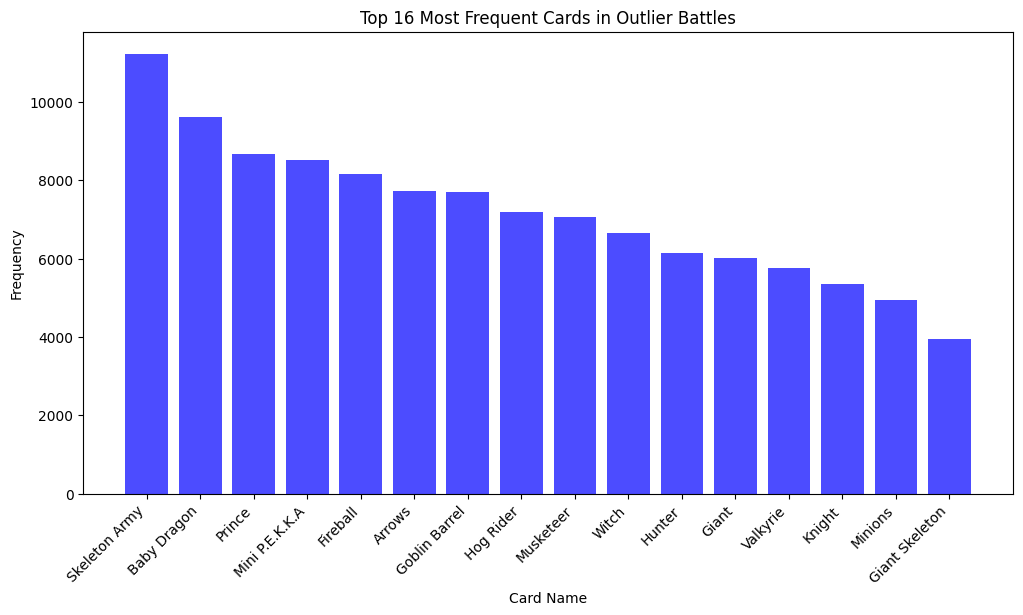

    Count       Card Name  Probability
1   11224   Skeleton Army     0.488999
2    9616     Baby Dragon     0.418943
23   8663          Prince     0.377423
18   8503  Mini P.E.K.K.A     0.370453
13   8166        Fireball     0.355770
14   7731          Arrows     0.336819
24   7692   Goblin Barrel     0.335120
10   7184       Hog Rider     0.312987
9    7061       Musketeer     0.307629
31   6661           Witch     0.290202
11   6148          Hunter     0.267852
20   6007           Giant     0.261709
58   5764        Valkyrie     0.251122
16   5344          Knight     0.232824
21   4947         Minions     0.215527
3    3951  Giant Skeleton     0.172134


In [81]:
from collections import Counter
# Extract rows from battles_df that match outlier_battles based on 'Unnamed: 0' column
outlier_battles_full = battles_df[battles_df["Unnamed: 0"].isin(outlier_battles["Unnamed: 0"])].copy()
# Initialize histogram counter
card_histogram = Counter()
# Update histogram with card sets
for cards in outlier_battles_full["winner_card_set"]:
    card_histogram.update(cards)
# Convert to DataFrame for plotting
card_hist_df = pd.DataFrame.from_dict(card_histogram, orient='index', columns=['Count']).reset_index()
card_hist_df.columns = ['Card Index', 'Count']
card_hist_df = card_hist_df.merge(card_list_df, left_on='Card Index', right_on='team.card1.id', how='left')
card_hist_df['Card Name'] = card_hist_df['team.card1.name'].fillna('Unknown')
total_outlier_battles = len(outlier_battles_full)
card_hist_df['Probability'] = card_hist_df['Count'] / total_outlier_battles

# Select only the top 16 most frequent cards for visualization
card_hist_df = card_hist_df.sort_values(by='Count', ascending=False).head(16)

# Plot histogram
plt.figure(figsize=(12,6))
plt.bar(card_hist_df['Card Name'], card_hist_df['Count'], color='blue', alpha=0.7)
plt.xlabel("Card Name")
plt.ylabel("Frequency")
plt.title("Top 16 Most Frequent Cards in Outlier Battles")
plt.xticks(rotation=45, ha='right')
plt.show()

# Print DataFrame with probabilities
card_hist_df.drop(columns=['Card Index', 'team.card1.id', 'team.card1.name'], inplace=True)
print(card_hist_df)


In [ ]:
winner_counts = battles_df["winner.tag"].value_counts()
loser_counts = battles_df["loser.tag"].value_counts()
battles_df["winner_count"] = battles_df["winner.tag"].map(winner_counts)
battles_df["winner_losing_count"] = battles_df["winner.tag"].map(loser_counts).fillna(0)
battles_df["total_games_for_winner"] = battles_df["winner_count"] + battles_df["winner_losing_count"]


In [97]:
print(battles_df.apply(lambda row: 1.0 if row["winner_losing_count"] == 0 else row["winner_count"] / row["total_games_for_winner"], axis=1))

0          0.774194
1          0.400000
2          0.589744
3          0.900000
4          0.654545
             ...   
2823522    0.333333
2823523    0.500000
2823524    0.500000
2823525    0.500000
2823526    0.500000
Length: 2823527, dtype: float64
